# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime,date
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder #OHC to encode data

In [3]:
from sklearn.ensemble import RandomForestClassifier 

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Grid Search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [6]:
from sklearn.metrics import confusion_matrix 

In [7]:
# Using accuracy score to evaluate the model
from sklearn.metrics import accuracy_score

In [8]:
#To plot ROC-AUC curve
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Data Pre Processing

In [9]:
oriData=pd.read_csv('ks-projects-201801.csv')

Once we have the origianl Dataset [oriData] ready, we will be making a few tweaks before it can be used for analysis

1) We will be introducing a new column "goal_met" to give an idea about the ratio between the amount of money pledged to the project and the amount of money received
<br>
2) We will be also introducing another column "days_between" to deduce the number of days between the date of launching the project and the deadline set for it.
<br>
3) We have dropped columns which we did not deem necessary to our analysis.

In [10]:
ksdata=oriData[['main_category', 'category','deadline', 'launched', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real', 'state']]
#ksDF
ksdata['goal_met']=ksdata.apply(lambda row: row['usd_pledged_real']/row['usd_goal_real'], axis=1)

def todt(row):
  return datetime.strptime(row.launched,  "%Y-%m-%d %H:%M:%S")

ksdata['launched']=ksdata.apply(lambda row: todt(row), axis = 1)  

ksdata['launched_year'] = ksdata.apply(lambda row: row['launched'].year, axis=1)

ksdata['launched_month']=ksdata.apply(lambda row: row['launched'].month, axis=1)


ksdata['launched']=pd.to_datetime(ksdata['launched']).dt.date
ksdata['deadline']=pd.to_datetime(ksdata['deadline']).dt.date

ksdata['days_between'] = ksdata['deadline'] - ksdata['launched']

ksdata=ksdata.drop(columns=['deadline', 'launched'])

ksdata['days_between'] = pd.to_numeric(ksdata['days_between'].dt.days, downcast='integer')

ksdata

<ipython-input-10-22cc540ef112>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksdata['goal_met']=ksdata.apply(lambda row: row['usd_pledged_real']/row['usd_goal_real'], axis=1)
<ipython-input-10-22cc540ef112>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksdata['launched']=ksdata.apply(lambda row: todt(row), axis = 1)
<ipython-input-10-22cc540ef112>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,main_category,category,backers,country,usd_pledged_real,usd_goal_real,state,goal_met,launched_year,launched_month,days_between
0,Publishing,Poetry,0,GB,0.0,1533.95,failed,0.000000,2015,8,59
1,Film & Video,Narrative Film,15,US,2421.0,30000.00,failed,0.080700,2017,9,60
2,Film & Video,Narrative Film,3,US,220.0,45000.00,failed,0.004889,2013,1,45
3,Music,Music,1,US,1.0,5000.00,failed,0.000200,2012,3,30
4,Film & Video,Film & Video,14,US,1283.0,19500.00,canceled,0.065795,2015,7,56
...,...,...,...,...,...,...,...,...,...,...,...
378656,Film & Video,Documentary,1,US,25.0,50000.00,canceled,0.000500,2014,9,30
378657,Film & Video,Narrative Film,5,US,155.0,1500.00,failed,0.103333,2011,6,27
378658,Film & Video,Narrative Film,1,US,20.0,15000.00,failed,0.001333,2010,7,46
378659,Technology,Technology,6,US,200.0,15000.00,failed,0.013333,2016,1,31


---
# Classification Models

We will only select entries with successful or failed state since the amount of data on other states are too little.

In [11]:
# Choose entries with either successful or failed state
sksdata=ksdata[ksdata.state=="successful"]
fksdata=ksdata[ksdata.state=="failed"]
ksdata=sksdata.append(fksdata, ignore_index=False)
ksdata=ksdata.reset_index(drop=True)

In [12]:
ksdata["state"].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

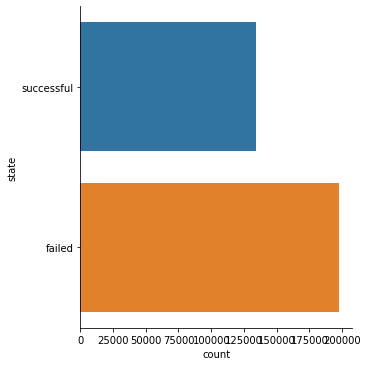

In [13]:
sb.catplot(y="state", data=ksdata, kind='count')

The data is quite balanced.

---
## 1. Classification models to predict projects passed deadline

With the projects whose deadlines have passed and the launch dates have been chosen yet have not been launched, we will determine whether they succeed or fail.

The features that are relevant and might be important in determining the outcomes (state) are main category, the number of backers, amount of pledged money, amount of goal money, launched month, days between deadline and launch. Except for the outcome (state), all other features are known. 

In [19]:
features=["main_category", "backers", "usd_pledged_real", "usd_goal_real", "launched_month", "days_between","state"]

In [20]:
trainData=ksdata[features]

In [21]:
trainData

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,Food,224,52375.00,50000.00,2,35,successful
1,Food,16,1205.00,1000.00,12,20,successful
2,Music,100,12700.00,12500.00,3,30,successful
3,Games,761,121857.33,6469.73,4,28,successful
4,Music,7,250.00,250.00,8,15,successful
...,...,...,...,...,...,...,...
331670,Food,4,154.00,6500.00,3,30,failed
331671,Film & Video,5,155.00,1500.00,6,27,failed
331672,Film & Video,1,20.00,15000.00,7,46,failed
331673,Technology,6,200.00,15000.00,1,31,failed


### Encoding with OneHotEncoder

We encode the main category and launched month using OneHotEncoder.

In [22]:
enc = OneHotEncoder()
ohencdf=pd.DataFrame(enc.fit_transform(trainData[["main_category"]]).toarray(), columns=enc.get_feature_names())
ohencdf.head()

,x0_Art,x0_Comics,x0_Crafts,x0_Dance,x0_Design,x0_Fashion,x0_Film & Video,x0_Food,x0_Games,x0_Journalism,x0_Music,x0_Photography,x0_Publishing,x0_Technology,x0_Theater
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
ohencdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   x0_Art           331675 non-null  float64
 1   x0_Comics        331675 non-null  float64
 2   x0_Crafts        331675 non-null  float64
 3   x0_Dance         331675 non-null  float64
 4   x0_Design        331675 non-null  float64
 5   x0_Fashion       331675 non-null  float64
 6   x0_Film & Video  331675 non-null  float64
 7   x0_Food          331675 non-null  float64
 8   x0_Games         331675 non-null  float64
 9   x0_Journalism    331675 non-null  float64
 10  x0_Music         331675 non-null  float64
 11  x0_Photography   331675 non-null  float64
 12  x0_Publishing    331675 non-null  float64
 13  x0_Technology    331675 non-null  float64
 14  x0_Theater       331675 non-null  float64
dtypes: float64(15)
memory usage: 38.0 MB


In [24]:
ohencdf2=pd.DataFrame(enc.fit_transform(trainData[["launched_month"]]).toarray(), columns=enc.get_feature_names())
ohencdf2.head()

,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We encode the state: successful to 1 and fail to 0 by a simple function.

In [25]:
# Encode class
def tobin(row):
  if row["state"]=="successful":
    return 1
  else:
    return 0
trainData['state'] = ksdata.apply(lambda row: tobin(row), axis=1)
trainData

<ipython-input-25-104cd27516a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData['state'] = ksdata.apply(lambda row: tobin(row), axis=1)


,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,Food,224,52375.00,50000.00,2,35,1
1,Food,16,1205.00,1000.00,12,20,1
2,Music,100,12700.00,12500.00,3,30,1
3,Games,761,121857.33,6469.73,4,28,1
4,Music,7,250.00,250.00,8,15,1
...,...,...,...,...,...,...,...
331670,Food,4,154.00,6500.00,3,30,0
331671,Film & Video,5,155.00,1500.00,6,27,0
331672,Film & Video,1,20.00,15000.00,7,46,0
331673,Technology,6,200.00,15000.00,1,31,0


Create X dataset concatenating the encoded data and the original data.

In [26]:
X=pd.concat([trainData, ohencdf.reindex(trainData.index), ohencdf2.reindex(trainData.index)], axis=1)
X

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state,x0_Art,x0_Comics,x0_Crafts,...,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
0,Food,224,52375.00,50000.00,2,35,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Food,16,1205.00,1000.00,12,20,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Music,100,12700.00,12500.00,3,30,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Games,761,121857.33,6469.73,4,28,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Music,7,250.00,250.00,8,15,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331670,Food,4,154.00,6500.00,3,30,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331671,Film & Video,5,155.00,1500.00,6,27,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
331672,Film & Video,1,20.00,15000.00,7,46,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
331673,Technology,6,200.00,15000.00,1,31,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
y=trainData["state"]
X=X.drop(columns=["main_category", "state", "launched_month"])

Next, we will make a RandomForestClassifier model to predict the outcome.

### Grid Search CV

We will use GridSearchCV for hyperparameter tuning. With this, we will find the best max_depth and n_estimators among some chosen values.

We will split our data into train data and validation data with a specified random state so as to get the same data sets every time running.

In [28]:
X_train, X_valid, y_train, y_valid= train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)

We will run Grid Search to find the best hyperparameters.

In [21]:
params = [{'max_depth': [6,7,8,9,10],
           'n_estimators': [150,200,250,300,350]}]
model = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=5)
model.fit(X_train, y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 200}

### Random Forest Classifier

After running GridSearchCV, we get the best max_depth as 10 and n_estimators as 200 so we create a new model with these hyperparameter values.

In [49]:
#RandomForestClassifier with max_depth of 10 and n_estimators of 200
model=RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)

In [50]:
# Fitting X_train and y_train 
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

### Evaluation

We will plot a confusion matrix and evaluate the accuracy.

<AxesSubplot:>

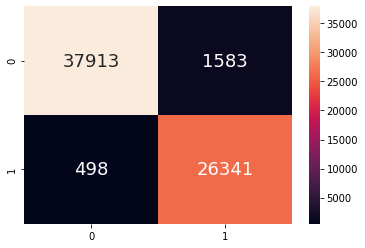

In [51]:
# Using model to predict on X_valid dataset
pred=model.predict(X_valid)
sb.heatmap(confusion_matrix(y_valid, pred), annot=True, fmt=".0f", annot_kws={"size":18})

In [52]:
print("Accuracy:")
print(accuracy_score(y_valid, pred))

Accuracy:
0.9686289289213839


To improve the model balance, we will plot ROC-AUC curve to find the best threshold.

Best Threshold=0.534453, G-Mean=0.972


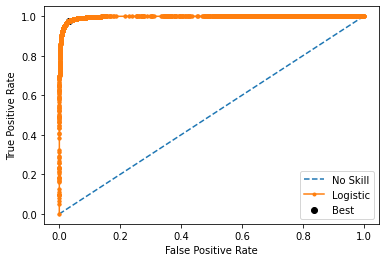

In [53]:
# predict probabilities
yhat = model.predict_proba(X_valid)
# keep probabilities for the successful outcome
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
#Set threshold to best threshold
prob_pred = model.predict_proba(X_valid)
threshold = thresholds[ix]
newpred = [1 if prob_pred[i][1]> threshold else 0 for i in range(len(prob_pred))]

We will recalculate the accuracy.

<AxesSubplot:>

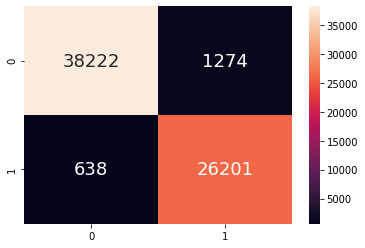

In [54]:
sb.heatmap(confusion_matrix(y_valid, newpred), annot=True, fmt=".0f", annot_kws={"size":18})

In [55]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, newpred))

0.9711766036029246


### Feature importance

We will check on the importance of each feature.

In [56]:
importances = list(zip(model.feature_importances_, X.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_pledged_real (0.42708239927127933)
2. backers (0.3736916731765161)
3. usd_goal_real (0.1620125217931363)
4. days_between (0.013935619622222796)
5. x0_Technology (0.005477055317073103)
6. x0_Music (0.004833626779975102)
7. x0_Theater (0.002296934824653434)
8. x0_Food (0.0017096445487361656)
9. x0_Design (0.0016358338964658277)
10. x0_Games (0.0014213942826907246)
11. x0_Fashion (0.0009985127784446653)
12. x0_Art (0.0009046994531012098)
13. x0_Comics (0.0008879040346151424)
14. x0_Dance (0.0005776521326284373)
15. x0_Publishing (0.00040173832652434457)
16. x0_Film & Video (0.00039661237175283746)
17. x0_Crafts (0.00033946884952802534)
18. x0_7 (0.0001543961555490947)
19. x0_Journalism (0.00012177447039808136)
20. x0_3 (0.00011173294951677896)
21. x0_Photography (0.00010740412702190844)
22. x0_12 (0.00010661630072298621)
23. x0_2 (9.611334730790706e-05)
24. x0_4 (9.499295570755562e-05)
25. x0_11 (9.462974146006508e-05)
26. x0_8 (8.898888940956356e-05)
27. x0_10 (8.889573379637593e-

The top four important features are the pledged amount, the nunmber of backers, the goal amount and the duration between launch and deadline. Category and launched month seems to be less important.

### Encode main_category and launched month to successful percentage

Previously, we treat each category and month equally but for this part, we will order them based on the successful rate of each category. 
We will do the same thing with launched month.

In [57]:
pd.set_option('display.max_rows', 1500)
successdata=ksdata.loc[ksdata.state=='successful']
#successdata
faildata=ksdata.loc[ksdata.state=='failed']
#faildata
sfdata=pd.concat([successdata,faildata])
sfdata=sfdata.reset_index()
cat_sfdata=sfdata.drop(['backers','country','usd_pledged_real','usd_goal_real','launched_year','launched_month','days_between','goal_met','category'], axis=1)
catdata=cat_sfdata.groupby(['main_category','state']).count()
ll=cat_sfdata.groupby(['main_category','state']).count().reset_index()
array=[]
array=np.array(ll['index'])
array2=np.array(ll['main_category'])
sfperct=[int(b/(a+b)*100) for a,b in zip(array[::2], array[1::2])]
sfname=[a for a,b in zip(array2[::2], array2[1::2])]
successd = pd.DataFrame({'Category': sfname, 'Success Percentage': sfperct}, columns=['Category', 'Success Percentage'])

In [58]:
month_sfdata=sfdata.drop(['main_category','backers','country','usd_pledged_real','usd_goal_real','launched_year','days_between','goal_met','category'], axis=1)
monthdata=month_sfdata.groupby(['launched_month','state']).count().reset_index()
#monthdata
month=[]
month=np.array(monthdata['index'])
month2=np.array(monthdata['launched_month'])
monthperct=[int(b/(a+b)*100) for a,b in zip(month[::2], month[1::2])]
monthname=[a for a,b in zip(month2[::2], month2[1::2])]
#month
successm = pd.DataFrame({'Month': monthname, 'Success Percentage': monthperct}, columns=['Month', 'Success Percentage'])

We create dictionaries with keys as category/month and values as the corresponding success rate.

In [59]:
sdict=pd.Series(successd["Success Percentage"].values,index=successd.Category).to_dict()
sdict2=pd.Series(successm["Success Percentage"].values,index=successm.Month).to_dict()

In [60]:
# Create a copy version to avoid changing the original one
trainData_=trainData.copy()

In [61]:
# Define 2 functions to encode 
def enccat(row):
  return sdict[row["main_category"]]
def encmonth(row):
  return sdict2[row["launched_month"]]

In [62]:
# Apply above functions on the dataframe
trainData_["main_category"]=trainData_.apply(lambda row: enccat(row), axis=1)
trainData_["launched_month"]=trainData_.apply(lambda row: encmonth(row), axis=1)
trainData_

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,27,224,52375.00,50000.00,41,35,1
1,27,16,1205.00,1000.00,37,20,1
2,52,100,12700.00,12500.00,42,30,1
3,43,761,121857.33,6469.73,42,28,1
4,52,7,250.00,250.00,38,15,1
...,...,...,...,...,...,...,...
331670,27,4,154.00,6500.00,42,30,0
331671,41,5,155.00,1500.00,40,27,0
331672,41,1,20.00,15000.00,36,46,0
331673,23,6,200.00,15000.00,38,31,0


In [63]:
# Prepare train data
y_=trainData_["state"]
X_=trainData_.drop(columns=["state"])

In [64]:
X_train_, X_valid_, y_train_, y_valid_= train_test_split(X_,y_,train_size=0.8, test_size=0.2, random_state=0)

#### Grid Search CV

In [30]:
# Use GridSearchCV to find the best hyperparameters
params = [{'max_depth': [6,7,8,9,10],
           'n_estimators': [150,200,250,300,350]}]
model_ = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=5)
model_.fit(X_train_, y_train_)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [6, 7, 8, 9, 10],
                          'n_estimators': [150, 200, 250, 300, 350]}],
             scoring='roc_auc')

In [31]:
# Print out the best parameters
model_.best_params_

{'max_depth': 10, 'n_estimators': 350}

In [65]:
# Create model with the parameters found
model_=RandomForestClassifier(n_estimators=350, max_depth=10, random_state=0)

In [66]:
model_.fit(X_train_, y_train_)

RandomForestClassifier(max_depth=10, n_estimators=350, random_state=0)

<AxesSubplot:>

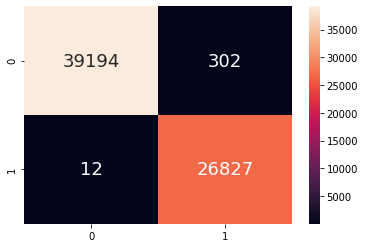

In [67]:
# Plotting confision matrix
pred_=model_.predict(X_valid_)
sb.heatmap(confusion_matrix(y_valid_, pred_), annot=True, fmt=".0f", annot_kws={"size":18})

In [68]:
# Evaluate using accuracy matrix
print("Accuracy:")
print(accuracy_score(y_valid_, pred_))

Accuracy:
0.9952664505916937


Best Threshold=0.596616, G-Mean=0.997


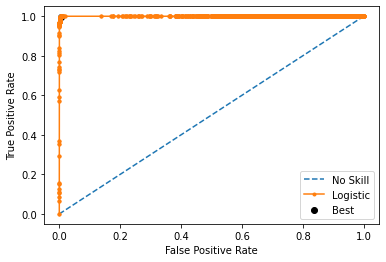

In [69]:
# predict probabilities
yhat = model_.predict_proba(X_valid_)
# keep probabilities for the successful outcome
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid_, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
#Set threshold to best threshold
prob_pred = model_.predict_proba(X_valid_)
threshold_ = thresholds[ix]
newpred_ = [1 if prob_pred[i][1]> threshold_ else 0 for i in range(len(prob_pred))]

<AxesSubplot:>

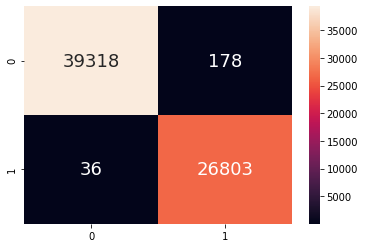

In [70]:
sb.heatmap(confusion_matrix(y_valid_, newpred_), annot=True, fmt=".0f", annot_kws={"size":18})

In [71]:
print("Accuracy:")
print(accuracy_score(y_valid_, newpred_))

Accuracy:
0.9967739504032562


Compared to the previous model, encoding in this new way slightly improves the accuracy.

We will check on the features importances

In [72]:
importances = list(zip(model_.feature_importances_, X_.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_pledged_real (0.37999679801355424)
2. backers (0.35612927463550625)
3. usd_goal_real (0.24071506611575602)
4. main_category (0.01395423695639161)
5. days_between (0.008702090369505663)
6. launched_month (0.0005025339092863738)


With the new encoding, main category appears to be more important while launched month still does not seem to have a more considerable influence on the state.

With this model, we are able to predict outcome of a project passed deadline with 99% confidence.

---
## 2. Classification models to predict projects before deadline

### RandomForestClassifier using OneHotEncoder to encode main category, launched month

For the projects that have not reach the deadlines yet and we want to predict whether it succeeds to decide to launch or to cancel.
Compared to previous model, we have not known the number of backers and pledged amount yet. 

First, we will try RandomForestClassifier and 

In [73]:
#drop backers and usd_pledged_real
y2=y
X2=X.drop(columns=['backers', 'usd_pledged_real'])

In [74]:
X2

,usd_goal_real,days_between,x0_Art,x0_Comics,x0_Crafts,x0_Dance,x0_Design,x0_Fashion,x0_Film & Video,x0_Food,...,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
0,50000.00,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000.00,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,12500.00,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6469.73,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,250.00,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331670,6500.00,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331671,1500.00,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
331672,15000.00,46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
331673,15000.00,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X_train2, X_valid2, y_train2, y_valid2= train_test_split(X2,y2,train_size=0.8, test_size=0.2, random_state=0)

Again, we use the GridSearchCV to choose the best hyperparameters.

In [ ]:
params = [{'max_depth': [11,12,13,14,15],
           'n_estimators': [150,200,250,300,350]}]
model2 = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=5)
model2.fit(X_train2, y_train2)
model2.best_params_
#The result is max_depth=15 and n_estimators=300

We create a model with the hyperparameters as above.

In [76]:
model2=RandomForestClassifier(n_estimators=300, max_depth=15, random_state=0)

In [77]:
model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=0)

<AxesSubplot:>

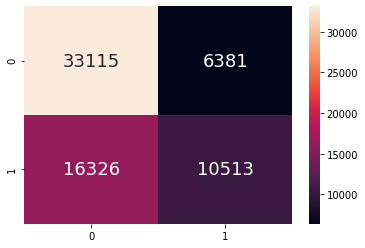

In [78]:
pred2=model2.predict(X_valid2)
sb.heatmap(confusion_matrix(y_valid2, pred2), annot=True, fmt=".0f", annot_kws={"size":18})

Best Threshold=0.413306, G-Mean=0.648


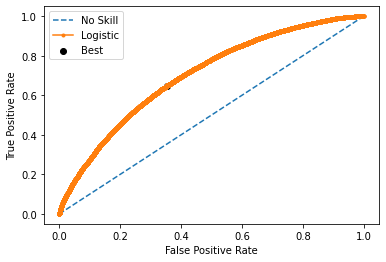

In [79]:
# predict probabilities
yhat = model2.predict_proba(X_valid2)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid2, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
#Set threshold to best thresholds
prob_pred2 = model2.predict_proba(X_valid2)
threshold2 = thresholds[ix]
newpred2 = [1 if prob_pred2[i][1]> threshold2 else 0 for i in range(len(prob_pred2))]

<AxesSubplot:>

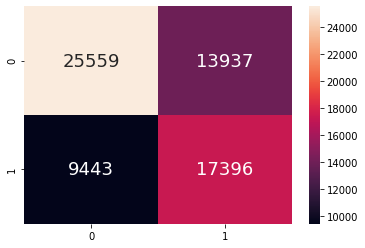

In [80]:
sb.heatmap(confusion_matrix(y_valid2, newpred2), annot=True, fmt=".0f", annot_kws={"size":18})

In [81]:
print("Accuracy:")
print(accuracy_score(y_valid2, pred2))

Accuracy:
0.6576920177884977


We will check on the features importance

In [82]:
importances = list(zip(model2.feature_importances_, X2.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_goal_real (0.45943074929157857)
2. days_between (0.26389920779921694)
3. x0_Music (0.04386754464879706)
4. x0_Technology (0.03697256480201706)
5. x0_Theater (0.03485924302178387)
6. x0_Fashion (0.023662315130997723)
7. x0_Comics (0.020281580618025864)
8. x0_Food (0.018156724863916816)
9. x0_Crafts (0.0122983419563212)
10. x0_Dance (0.01161536301772125)
11. x0_Publishing (0.010981959299692824)
12. x0_Games (0.007019703085029729)
13. x0_Film & Video (0.006162980127614043)
14. x0_Journalism (0.005759227399659345)
15. x0_Design (0.0050750727949802005)
16. x0_7 (0.004781510938810972)
17. x0_Photography (0.004576217726357304)
18. x0_12 (0.0034022080349352386)
19. x0_Art (0.0031091254162084387)
20. x0_1 (0.0026575489362835668)
21. x0_10 (0.002548103175536028)
22. x0_8 (0.0025368620306584406)
23. x0_4 (0.002498755969470647)
24. x0_3 (0.0024779302849137603)
25. x0_2 (0.002357370026679206)
26. x0_11 (0.0022746638283649735)
27. x0_9 (0.002265872979922407)
28. x0_6 (0.0022453591574908257)
2

Launched month seems to have the least importance while goal has the highest importance, followed by days between.

### RandomForestClassifier with encoding main category and launched month to corresponding success rate

In [83]:
trainData_

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,27,224,52375.00,50000.00,41,35,1
1,27,16,1205.00,1000.00,37,20,1
2,52,100,12700.00,12500.00,42,30,1
3,43,761,121857.33,6469.73,42,28,1
4,52,7,250.00,250.00,38,15,1
...,...,...,...,...,...,...,...
331670,27,4,154.00,6500.00,42,30,0
331671,41,5,155.00,1500.00,40,27,0
331672,41,1,20.00,15000.00,36,46,0
331673,23,6,200.00,15000.00,38,31,0


In [84]:
_X=trainData_[["main_category", "usd_goal_real", "launched_month", "days_between"]]
_y=trainData_["state"]

In [85]:
_X_train, _X_valid, _y_train, _y_valid= train_test_split(_X,_y,train_size=0.8, test_size=0.2, random_state=0)

We will use GridSearchCV for hyperparameters tuning.

In [37]:
params = [{'max_depth': [7,8,9,10,11],
           'n_estimators': [150,200,250,300,350]}]
_model = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=5)
_model.fit(_X_train, _y_train)
_model.best_params_

{'max_depth': 11, 'n_estimators': 250}

In [86]:
_model=RandomForestClassifier(n_estimators=250, max_depth=11, random_state=0)

In [87]:
_model.fit(_X_train, _y_train)

RandomForestClassifier(max_depth=11, n_estimators=250, random_state=0)

<AxesSubplot:>

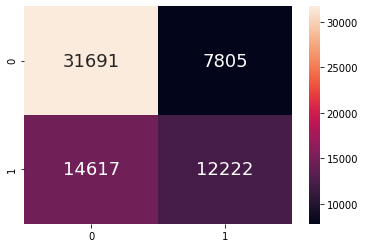

In [88]:
_pred=_model.predict(_X_valid)
sb.heatmap(confusion_matrix(_y_valid, _pred), annot=True, fmt=".0f", annot_kws={"size":18})

Best Threshold=0.413430, G-Mean=0.648


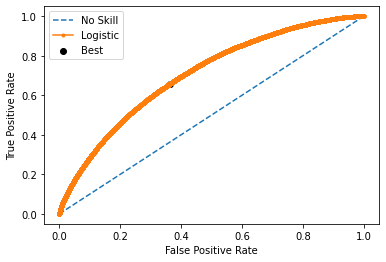

In [89]:
# predict probabilities
yhat = _model.predict_proba(_X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(_y_valid, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
#Set threshold best threshold
_prob_pred = _model.predict_proba(_X_valid)
_threshold = thresholds[ix]
_newpred = [1 if _prob_pred[i][1]> _threshold else 0 for i in range(len(_prob_pred))]

<AxesSubplot:>

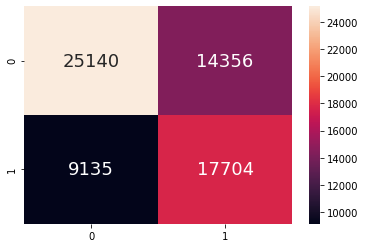

In [90]:
sb.heatmap(confusion_matrix(_y_valid, _newpred), annot=True, fmt=".0f", annot_kws={"size":18})

In [91]:
print(accuracy_score(_y_valid, _newpred))

0.6458732192658476


In [92]:
importances = list(zip(_model.feature_importances_, _X.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_goal_real (0.4256557947643622)
2. main_category (0.2874142573686789)
3. days_between (0.2528250646479115)
4. launched_month (0.034104883219047394)


After encoding main category to the corresponding success rate, its importance increases and overtakes days between.

---
### Resampling the dataset

To reach a higher accuracy, We will try resampling the outcome.

In [93]:
trainData

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,Food,224,52375.00,50000.00,2,35,1
1,Food,16,1205.00,1000.00,12,20,1
2,Music,100,12700.00,12500.00,3,30,1
3,Games,761,121857.33,6469.73,4,28,1
4,Music,7,250.00,250.00,8,15,1
...,...,...,...,...,...,...,...
331670,Food,4,154.00,6500.00,3,30,0
331671,Film & Video,5,155.00,1500.00,6,27,0
331672,Film & Video,1,20.00,15000.00,7,46,0
331673,Technology,6,200.00,15000.00,1,31,0


In [94]:
trainData.state.value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [95]:
# Resampling
import sklearn
fail=trainData[trainData["state"]==0]
fail

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
133956,Publishing,0,0.0,1533.95,8,59,0
133957,Film & Video,15,2421.0,30000.00,9,60,0
133958,Film & Video,3,220.0,45000.00,1,45,0
133959,Music,1,1.0,5000.00,3,30,0
133960,Food,40,453.0,25000.00,2,45,0
...,...,...,...,...,...,...,...
331670,Food,4,154.0,6500.00,3,30,0
331671,Film & Video,5,155.0,1500.00,6,27,0
331672,Film & Video,1,20.0,15000.00,7,46,0
331673,Technology,6,200.0,15000.00,1,31,0


In [96]:
resample=sklearn.utils.resample(trainData[trainData["state"]==1], n_samples=fail.shape[0])
resampleData=pd.concat([fail, resample])
resampleData

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
133956,Publishing,0,0.00,1533.95,8,59,0
133957,Film & Video,15,2421.00,30000.00,9,60,0
133958,Film & Video,3,220.00,45000.00,1,45,0
133959,Music,1,1.00,5000.00,3,30,0
133960,Food,40,453.00,25000.00,2,45,0
...,...,...,...,...,...,...,...
9548,Art,355,14405.00,5000.00,3,31,1
44169,Theater,27,1101.00,1000.00,8,19,1
5098,Art,164,17803.00,12500.00,8,30,1
76964,Film & Video,26,1970.12,1970.12,12,25,1


In [97]:
resampleData.reset_index(drop=True)

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,Publishing,0,0.00,1533.95,8,59,0
1,Film & Video,15,2421.00,30000.00,9,60,0
2,Film & Video,3,220.00,45000.00,1,45,0
3,Music,1,1.00,5000.00,3,30,0
4,Food,40,453.00,25000.00,2,45,0
...,...,...,...,...,...,...,...
395433,Art,355,14405.00,5000.00,3,31,1
395434,Theater,27,1101.00,1000.00,8,19,1
395435,Art,164,17803.00,12500.00,8,30,1
395436,Film & Video,26,1970.12,1970.12,12,25,1


In [98]:
resampleData.state.value_counts()

0    197719
1    197719
Name: state, dtype: int64

#### Encode main category and launched month by OneHotEncoder

In [99]:
# Encoding main category 
enc = OneHotEncoder()
ohencdf3=pd.DataFrame(enc.fit_transform(resampleData[["main_category"]]).toarray(), columns=enc.get_feature_names())

In [100]:
ohencdf3

,x0_Art,x0_Comics,x0_Crafts,x0_Dance,x0_Design,x0_Fashion,x0_Film & Video,x0_Food,x0_Games,x0_Journalism,x0_Music,x0_Photography,x0_Publishing,x0_Technology,x0_Theater
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395433,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395435,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395436,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# Encoding launched month
ohencdf4=pd.DataFrame(enc.fit_transform(resampleData[["launched_month"]]).toarray(), columns=enc.get_feature_names())
ohencdf4

,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395433,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
395435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
395436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [102]:
encdf=pd.merge(ohencdf4, ohencdf3, left_index=True, right_index=True)
encdf

,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,...,x0_Fashion,x0_Film & Video,x0_Food,x0_Games,x0_Journalism,x0_Music,x0_Photography,x0_Publishing,x0_Technology,x0_Theater
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395433,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
encdf=encdf.reset_index(drop=True)

In [104]:
resampleData=resampleData.reset_index(drop=True)

In [105]:
X3=pd.concat([resampleData, encdf], axis=1)

In [106]:
X3

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state,x0_1,x0_2,x0_3,...,x0_Fashion,x0_Film & Video,x0_Food,x0_Games,x0_Journalism,x0_Music,x0_Photography,x0_Publishing,x0_Technology,x0_Theater
0,Publishing,0,0.00,1533.95,8,59,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Film & Video,15,2421.00,30000.00,9,60,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Film & Video,3,220.00,45000.00,1,45,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Music,1,1.00,5000.00,3,30,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Food,40,453.00,25000.00,2,45,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395433,Art,355,14405.00,5000.00,3,31,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395434,Theater,27,1101.00,1000.00,8,19,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395435,Art,164,17803.00,12500.00,8,30,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395436,Film & Video,26,1970.12,1970.12,12,25,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
y3=X3['state']
X3=X3.drop(columns=['main_category', 'backers', 'usd_pledged_real', 'state', 'launched_month'])
X3

,usd_goal_real,days_between,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,...,x0_Fashion,x0_Film & Video,x0_Food,x0_Games,x0_Journalism,x0_Music,x0_Photography,x0_Publishing,x0_Technology,x0_Theater
0,1533.95,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,30000.00,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45000.00,45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5000.00,30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,25000.00,45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395433,5000.00,31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395434,1000.00,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395435,12500.00,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395436,1970.12,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
X_train3, X_valid3, y_train3, y_valid3= train_test_split(X3,y3,train_size=0.8, test_size=0.2, random_state=0)

In [40]:
#GridSearchCV
params = [{'max_depth': [23,24,25,26,27],
           'n_estimators': [150,200,250,300,350]}]
model3 = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=3)
model3.fit(X_train3, y_train3)
model3.best_params_

{'max_depth': 26, 'n_estimators': 350}

In [109]:
model3=RandomForestClassifier(n_estimators=350, max_depth=26, random_state=0)

In [110]:
model3.fit(X_train3, y_train3)

RandomForestClassifier(max_depth=26, n_estimators=350, random_state=0)

<AxesSubplot:>

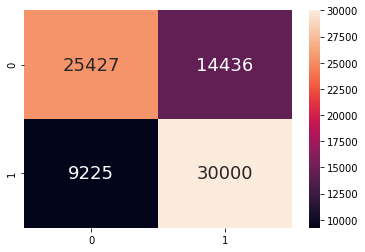

In [111]:
pred3=model3.predict(X_valid3)
sb.heatmap(confusion_matrix(y_valid3, pred3), annot=True, fmt=".0f", annot_kws={"size":18})

In [112]:
print(accuracy_score(y_valid3, pred3))

0.7008269269674287


Best Threshold=0.539542, G-Mean=0.704


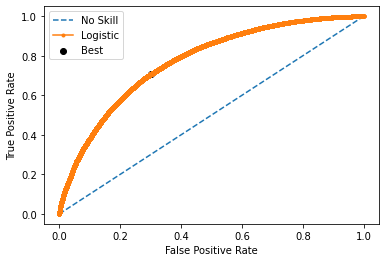

In [113]:
# predict probabilities
yhat = model3.predict_proba(X_valid3)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid3, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot2
pyplot.show()
#Set threshold to thresholds[ix]
prob_pred3 = model3.predict_proba(X_valid3)
threshold3 = thresholds[ix]
newpred3 = [1 if prob_pred3[i][1]> threshold3 else 0 for i in range(len(prob_pred3))]

<AxesSubplot:>

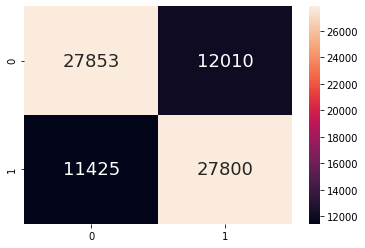

In [114]:
sb.heatmap(confusion_matrix(y_valid3, newpred3), annot=True, fmt=".0f", annot_kws={"size":18})

In [115]:
print(accuracy_score(y_valid3, newpred3))

0.7036845033380538


This is the best accuracy we have obtained.

In [116]:
importances = list(zip(model3.feature_importances_, X3.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_goal_real (0.5788263849381822)
2. days_between (0.2607616791584101)
3. x0_Music (0.016655881287314277)
4. x0_Technology (0.014152479632600865)
5. x0_Theater (0.011832804315313463)
6. x0_Fashion (0.010550412482914317)
7. x0_Comics (0.008577887463624968)
8. x0_Food (0.00790564378171309)
9. x0_Crafts (0.006332388070469939)
10. x0_Publishing (0.0060655817356318085)
11. x0_Dance (0.00504995318933912)
12. x0_7 (0.004616148787967207)
13. x0_Film & Video (0.0045968279274328505)
14. x0_Games (0.0045651476722454185)
15. x0_Design (0.004292488842900021)
16. x0_Journalism (0.004262079901951744)
17. x0_12 (0.004155073388734592)
18. x0_9 (0.004114030854188848)
19. x0_1 (0.004077410667312298)
20. x0_11 (0.0040701980246655705)
21. x0_6 (0.004055349559686998)
22. x0_5 (0.004032191845569669)
23. x0_2 (0.00400568296046202)
24. x0_10 (0.004001629387674208)
25. x0_3 (0.003970918902140673)
26. x0_8 (0.003931630136580356)
27. x0_4 (0.003882710224066564)
28. x0_Photography (0.003580273847550176)
29. x0

For this model, goal and days between are the most important.

#### Encode launched month and main category to successful percentage on resampled data

In [117]:
_resampleData=resampleData.copy()

In [118]:
_resampleData["main_category"]=_resampleData.apply(lambda row:enccat(row), axis=1)
_resampleData["launched_month"]=_resampleData.apply(lambda row:encmonth(row), axis=1)

In [119]:
_resampleData

,main_category,backers,usd_pledged_real,usd_goal_real,launched_month,days_between,state
0,34,0,0.00,1533.95,38,59,0
1,41,15,2421.00,30000.00,40,60,0
2,41,3,220.00,45000.00,38,45,0
3,52,1,1.00,5000.00,42,30,0
4,27,40,453.00,25000.00,41,45,0
...,...,...,...,...,...,...,...
395433,44,355,14405.00,5000.00,42,31,1
395434,63,27,1101.00,1000.00,38,19,1
395435,44,164,17803.00,12500.00,38,30,1
395436,41,26,1970.12,1970.12,37,25,1


In [120]:
_X2=_resampleData[["main_category", "usd_goal_real", "launched_month", "days_between"]]
_y2=_resampleData["state"]

In [121]:
_X_train2, _X_valid2, _y_train2, _y_valid2= train_test_split(_X2,_y2,train_size=0.8, test_size=0.2, random_state=0)

In [208]:
#GridSearchCV
params = [{'max_depth': [23,24,25,26,27],
           'n_estimators': [150,200,250,300,350]}]
_model2 = GridSearchCV(RandomForestClassifier(),param_grid=params, scoring='roc_auc', cv=5)
_model2.fit(_X_train2, _y_train2)
_model2.best_params_

{'max_depth': 23, 'n_estimators': 350}

In [122]:
_model2=RandomForestClassifier(n_estimators=350, max_depth=23, random_state=0)

In [123]:
_model2.fit(_X_train2, _y_train2)

RandomForestClassifier(max_depth=23, n_estimators=350, random_state=0)

<AxesSubplot:>

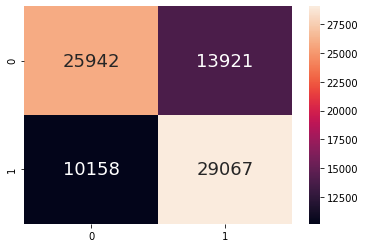

In [124]:
_pred2=_model2.predict(_X_valid2)
sb.heatmap(confusion_matrix(_y_valid2, _pred2), annot=True, fmt=".0f", annot_kws={"size":18})

Best Threshold=0.541043, G-Mean=0.697


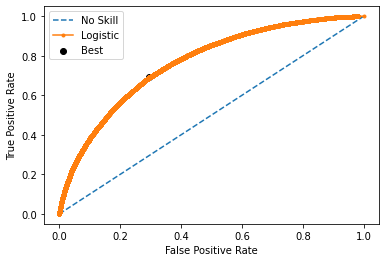

In [125]:
# predict probabilities
yhat = _model2.predict_proba(_X_valid2)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(_y_valid2, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
#Set threshold to best threshold
_prob_pred2 = _model2.predict_proba(_X_valid2)
_threshold2 = thresholds[ix]
_newpred2 = [1 if _prob_pred2[i][1]> _threshold2 else 0 for i in range(len(_prob_pred2))]

<AxesSubplot:>

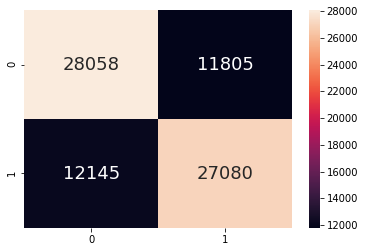

In [126]:
sb.heatmap(confusion_matrix(_y_valid2, _newpred2), annot=True, fmt=".0f", annot_kws={"size":18})

In [127]:
print(accuracy_score(_y_valid2, _newpred2))

0.6971727695731337


In [128]:
importances = list(zip(_model2.feature_importances_, _X2.columns))
importances.sort(reverse=True)
# Print feature ranking
i=1
for f in importances:
  print("{}. {} ({})".format(i, f[1],f[0]))
  i=i+1

1. usd_goal_real (0.5944814448533551)
2. days_between (0.20037074123212298)
3. main_category (0.12419632513881318)
4. launched_month (0.08095148877570883)


For this model, goal seems to be very important, while others does not.

### Using XGBClassifier

In [ ]:
#Try XGBClassifier.
from xgboost import XGBClassifier
my_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train2, y_train2, 
             early_stopping_rounds=10, 
             eval_set=[(X_valid2, y_valid2)], 
             verbose=False)

In [120]:
my_pred=my_model.predict(X_valid2)

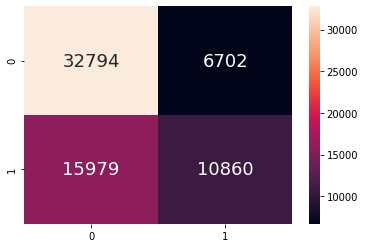

In [121]:
sb.heatmap(confusion_matrix(y_valid2, my_pred), annot=True, fmt=".0f", annot_kws={"size":18})

Best Threshold=0.416665, G-Mean=0.647


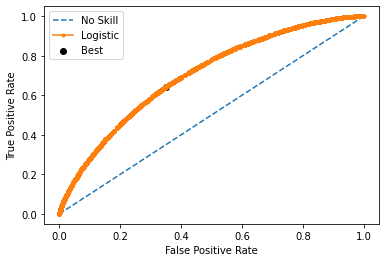

In [122]:
# predict probabilities
yhat = my_model.predict_proba(X_valid2)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid2, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot2
pyplot.show()

In [123]:
#Set threshold to 0.416665
myprob_pred = my_model.predict_proba(X_valid2)
mythreshold = 0.416665
mynewpred = [1 if myprob_pred[i][1]> mythreshold else 0 for i in range(len(myprob_pred))]

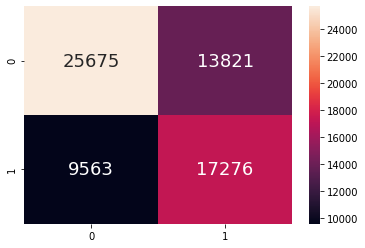

In [124]:
sb.heatmap(confusion_matrix(y_valid2, mynewpred), annot=True, fmt=".0f", annot_kws={"size":18})

In [125]:
print(accuracy_score(y_valid2, mynewpred))

0.6474862440642195


This does not improve accuracy.

---
## Decision Tree

Since the pledged amount, goal amount, number of backers and the days between seem to be the most important, we will examine how these variables affect the state by creating and plotting a decision tree.

We will choose predictors: goal, backers and days between to see with the goal we set, how many backers we should expect and when to launch the project. 

In [203]:
from sklearn.tree import DecisionTreeClassifier
predictors = ["usd_goal_real", "backers", "days_between"]

y_dt = pd.DataFrame(trainData['state'])
X_dt = pd.DataFrame(trainData[predictors]) 

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size = 0.25)

dectree = DecisionTreeClassifier(max_depth = 3)  
dectree.fit(X_train_dt, y_train_dt)                  

y_train_pred = dectree.predict(X_train_dt)
y_test_pred = dectree.predict(X_test_dt)

[Text(837.0, 1426.95, 'backers <= 17.5\ngini = 0.482\nsamples = 248756\nvalue = [148096, 100660]\nclass = failed'),
 Text(418.5, 1019.25, 'usd_goal_real <= 808.625\ngini = 0.154\nsamples = 130590\nvalue = [119614, 10976]\nclass = failed'),
 Text(209.25, 611.55, 'backers <= 5.5\ngini = 0.465\nsamples = 20767\nvalue = [13135, 7632]\nclass = failed'),
 Text(104.625, 203.8499999999999, 'gini = 0.2\nsamples = 12842\nvalue = [11397, 1445]\nclass = failed'),
 Text(313.875, 203.8499999999999, 'gini = 0.342\nsamples = 7925\nvalue = [1738, 6187]\nclass = successful'),
 Text(627.75, 611.55, 'backers <= 10.5\ngini = 0.059\nsamples = 109823\nvalue = [106479, 3344]\nclass = failed'),
 Text(523.125, 203.8499999999999, 'gini = 0.02\nsamples = 95587\nvalue = [94600, 987]\nclass = failed'),
 Text(732.375, 203.8499999999999, 'gini = 0.276\nsamples = 14236\nvalue = [11879, 2357]\nclass = failed'),
 Text(1255.5, 1019.25, 'usd_goal_real <= 8403.08\ngini = 0.366\nsamples = 118166\nvalue = [28482, 89684]\ncla

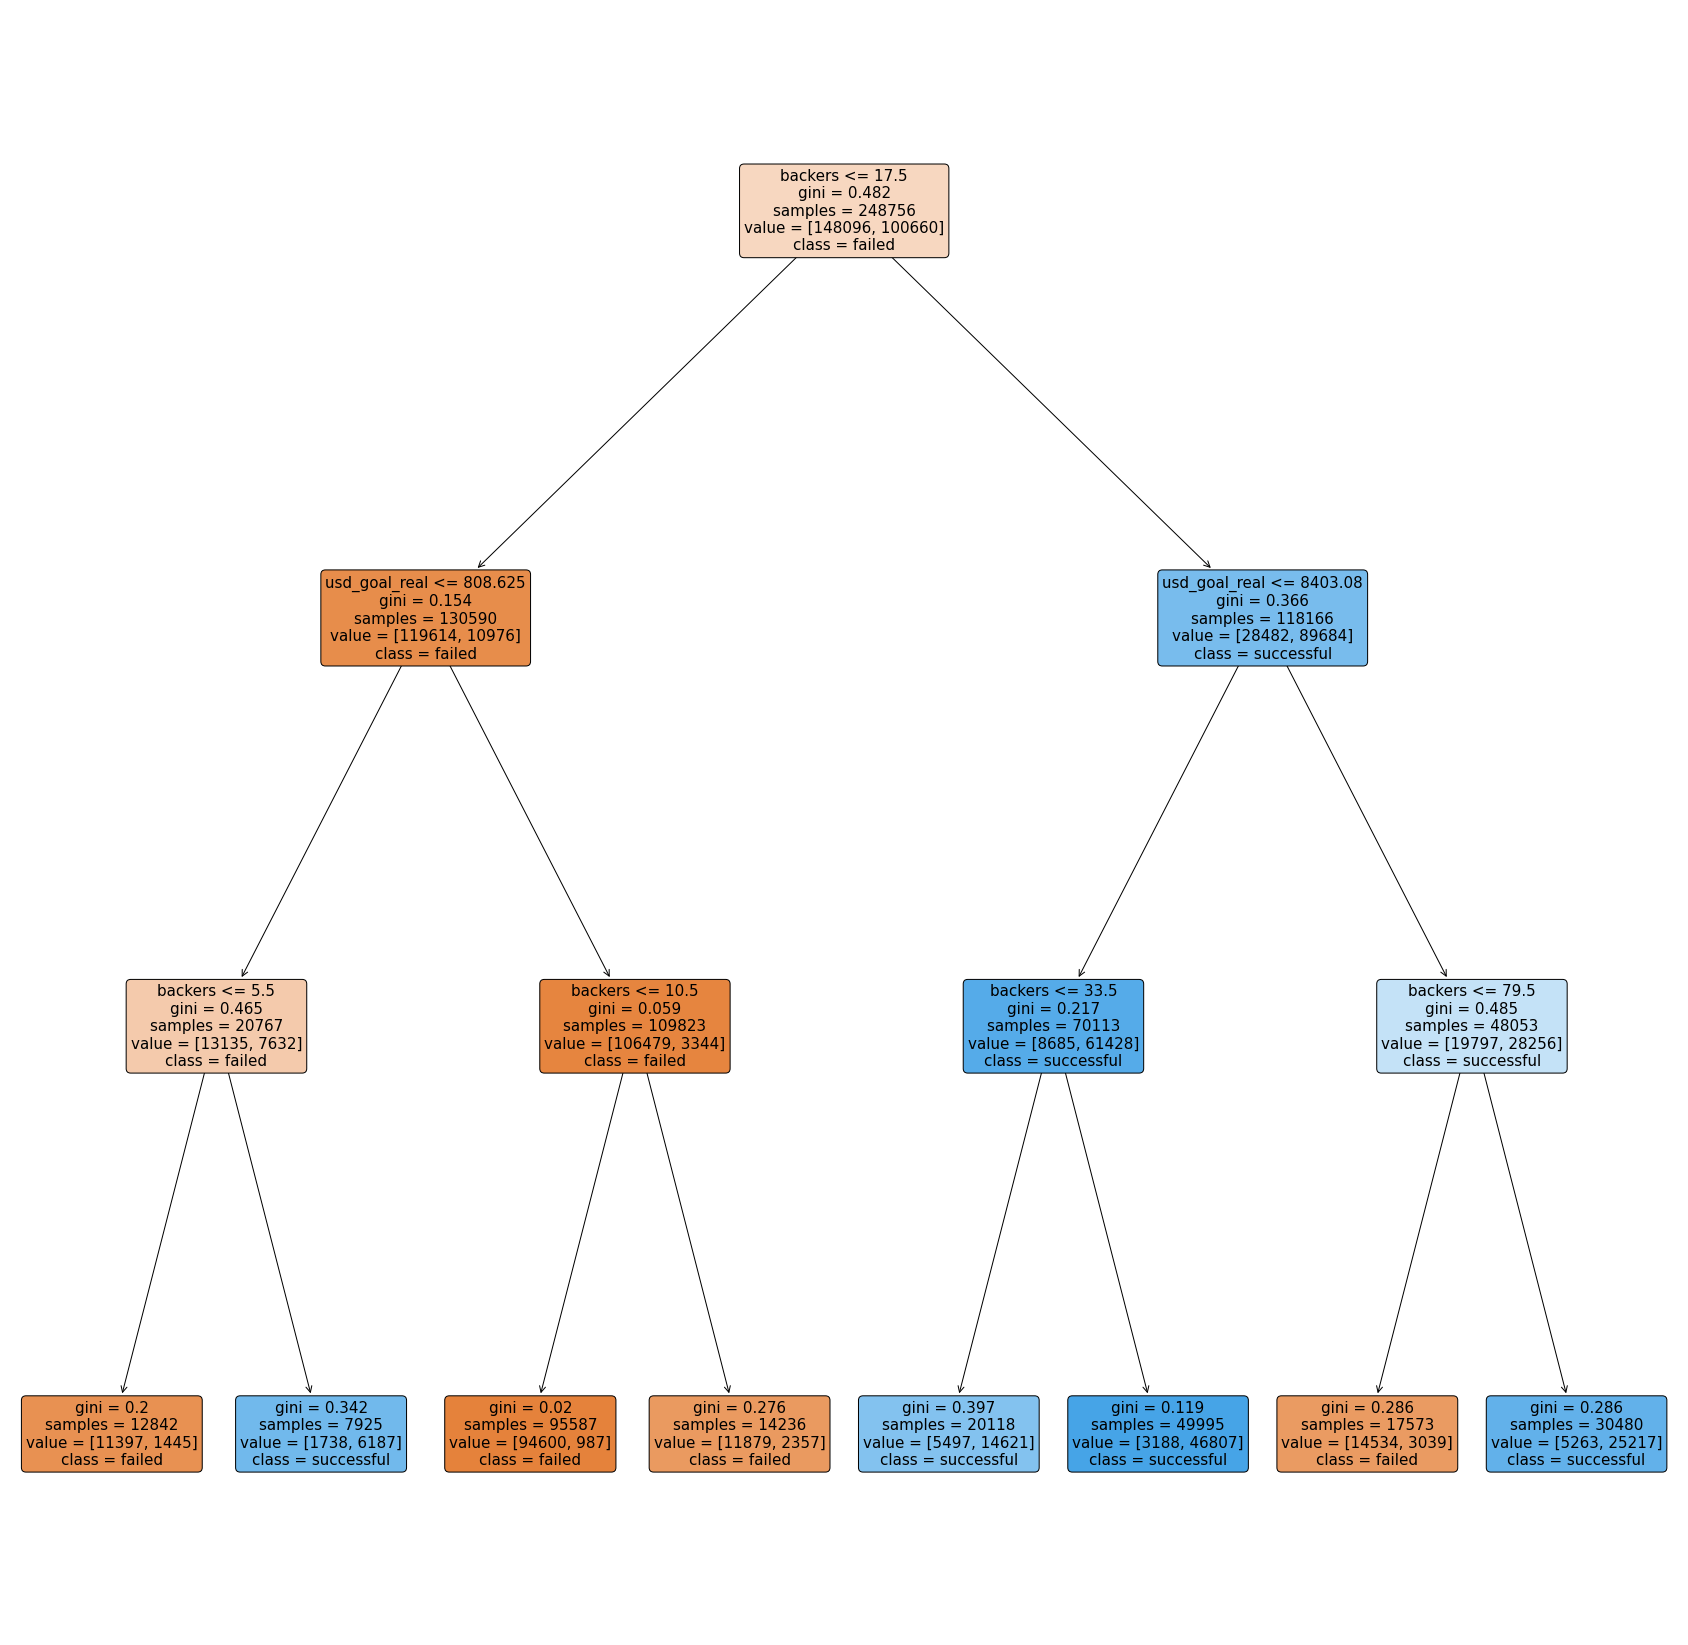

In [204]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(30,30))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train_dt.columns, 
          class_names=["failed","successful"])

According to the tree with depth=3, if the number of backers is smaller than 18, there will be a high probablity of failure. However, if the goal amount is smaller than 808 USD and the project has more than 5 backers (get at least 160 USD per backer), there is still chances of success. (78%)
Meanwhile, if the number of backers is larger than 17 but smaller than 79 and the goal is larger than about 8400 (cannot reach 105 USD for each backer), there is about 83% possibility of failure.

We will plot a tree with depth of 5 to see if days between affect the state. 

In [205]:
dectree2 = DecisionTreeClassifier(max_depth = 5)  
dectree2.fit(X_train_dt, y_train_dt)                  

y_train_pred2 = dectree2.predict(X_train_dt)
y_test_pred2 = dectree2.predict(X_test_dt)

[Text(2232.0, 3986.4, 'backers <= 17.5\ngini = 0.482\nsamples = 248756\nvalue = [148096, 100660]\nclass = failed'),
 Text(1116.0, 3261.6000000000004, 'usd_goal_real <= 808.625\ngini = 0.154\nsamples = 130590\nvalue = [119614, 10976]\nclass = failed'),
 Text(558.0, 2536.8, 'backers <= 5.5\ngini = 0.465\nsamples = 20767\nvalue = [13135, 7632]\nclass = failed'),
 Text(279.0, 1812.0, 'usd_goal_real <= 137.27\ngini = 0.2\nsamples = 12842\nvalue = [11397, 1445]\nclass = failed'),
 Text(139.5, 1087.1999999999998, 'backers <= 1.5\ngini = 0.45\nsamples = 2670\nvalue = [1759, 911]\nclass = failed'),
 Text(69.75, 362.39999999999964, 'gini = 0.218\nsamples = 1515\nvalue = [1326, 189]\nclass = failed'),
 Text(209.25, 362.39999999999964, 'gini = 0.469\nsamples = 1155\nvalue = [433, 722]\nclass = successful'),
 Text(418.5, 1087.1999999999998, 'backers <= 3.5\ngini = 0.099\nsamples = 10172\nvalue = [9638, 534]\nclass = failed'),
 Text(348.75, 362.39999999999964, 'gini = 0.045\nsamples = 8501\nvalue = 

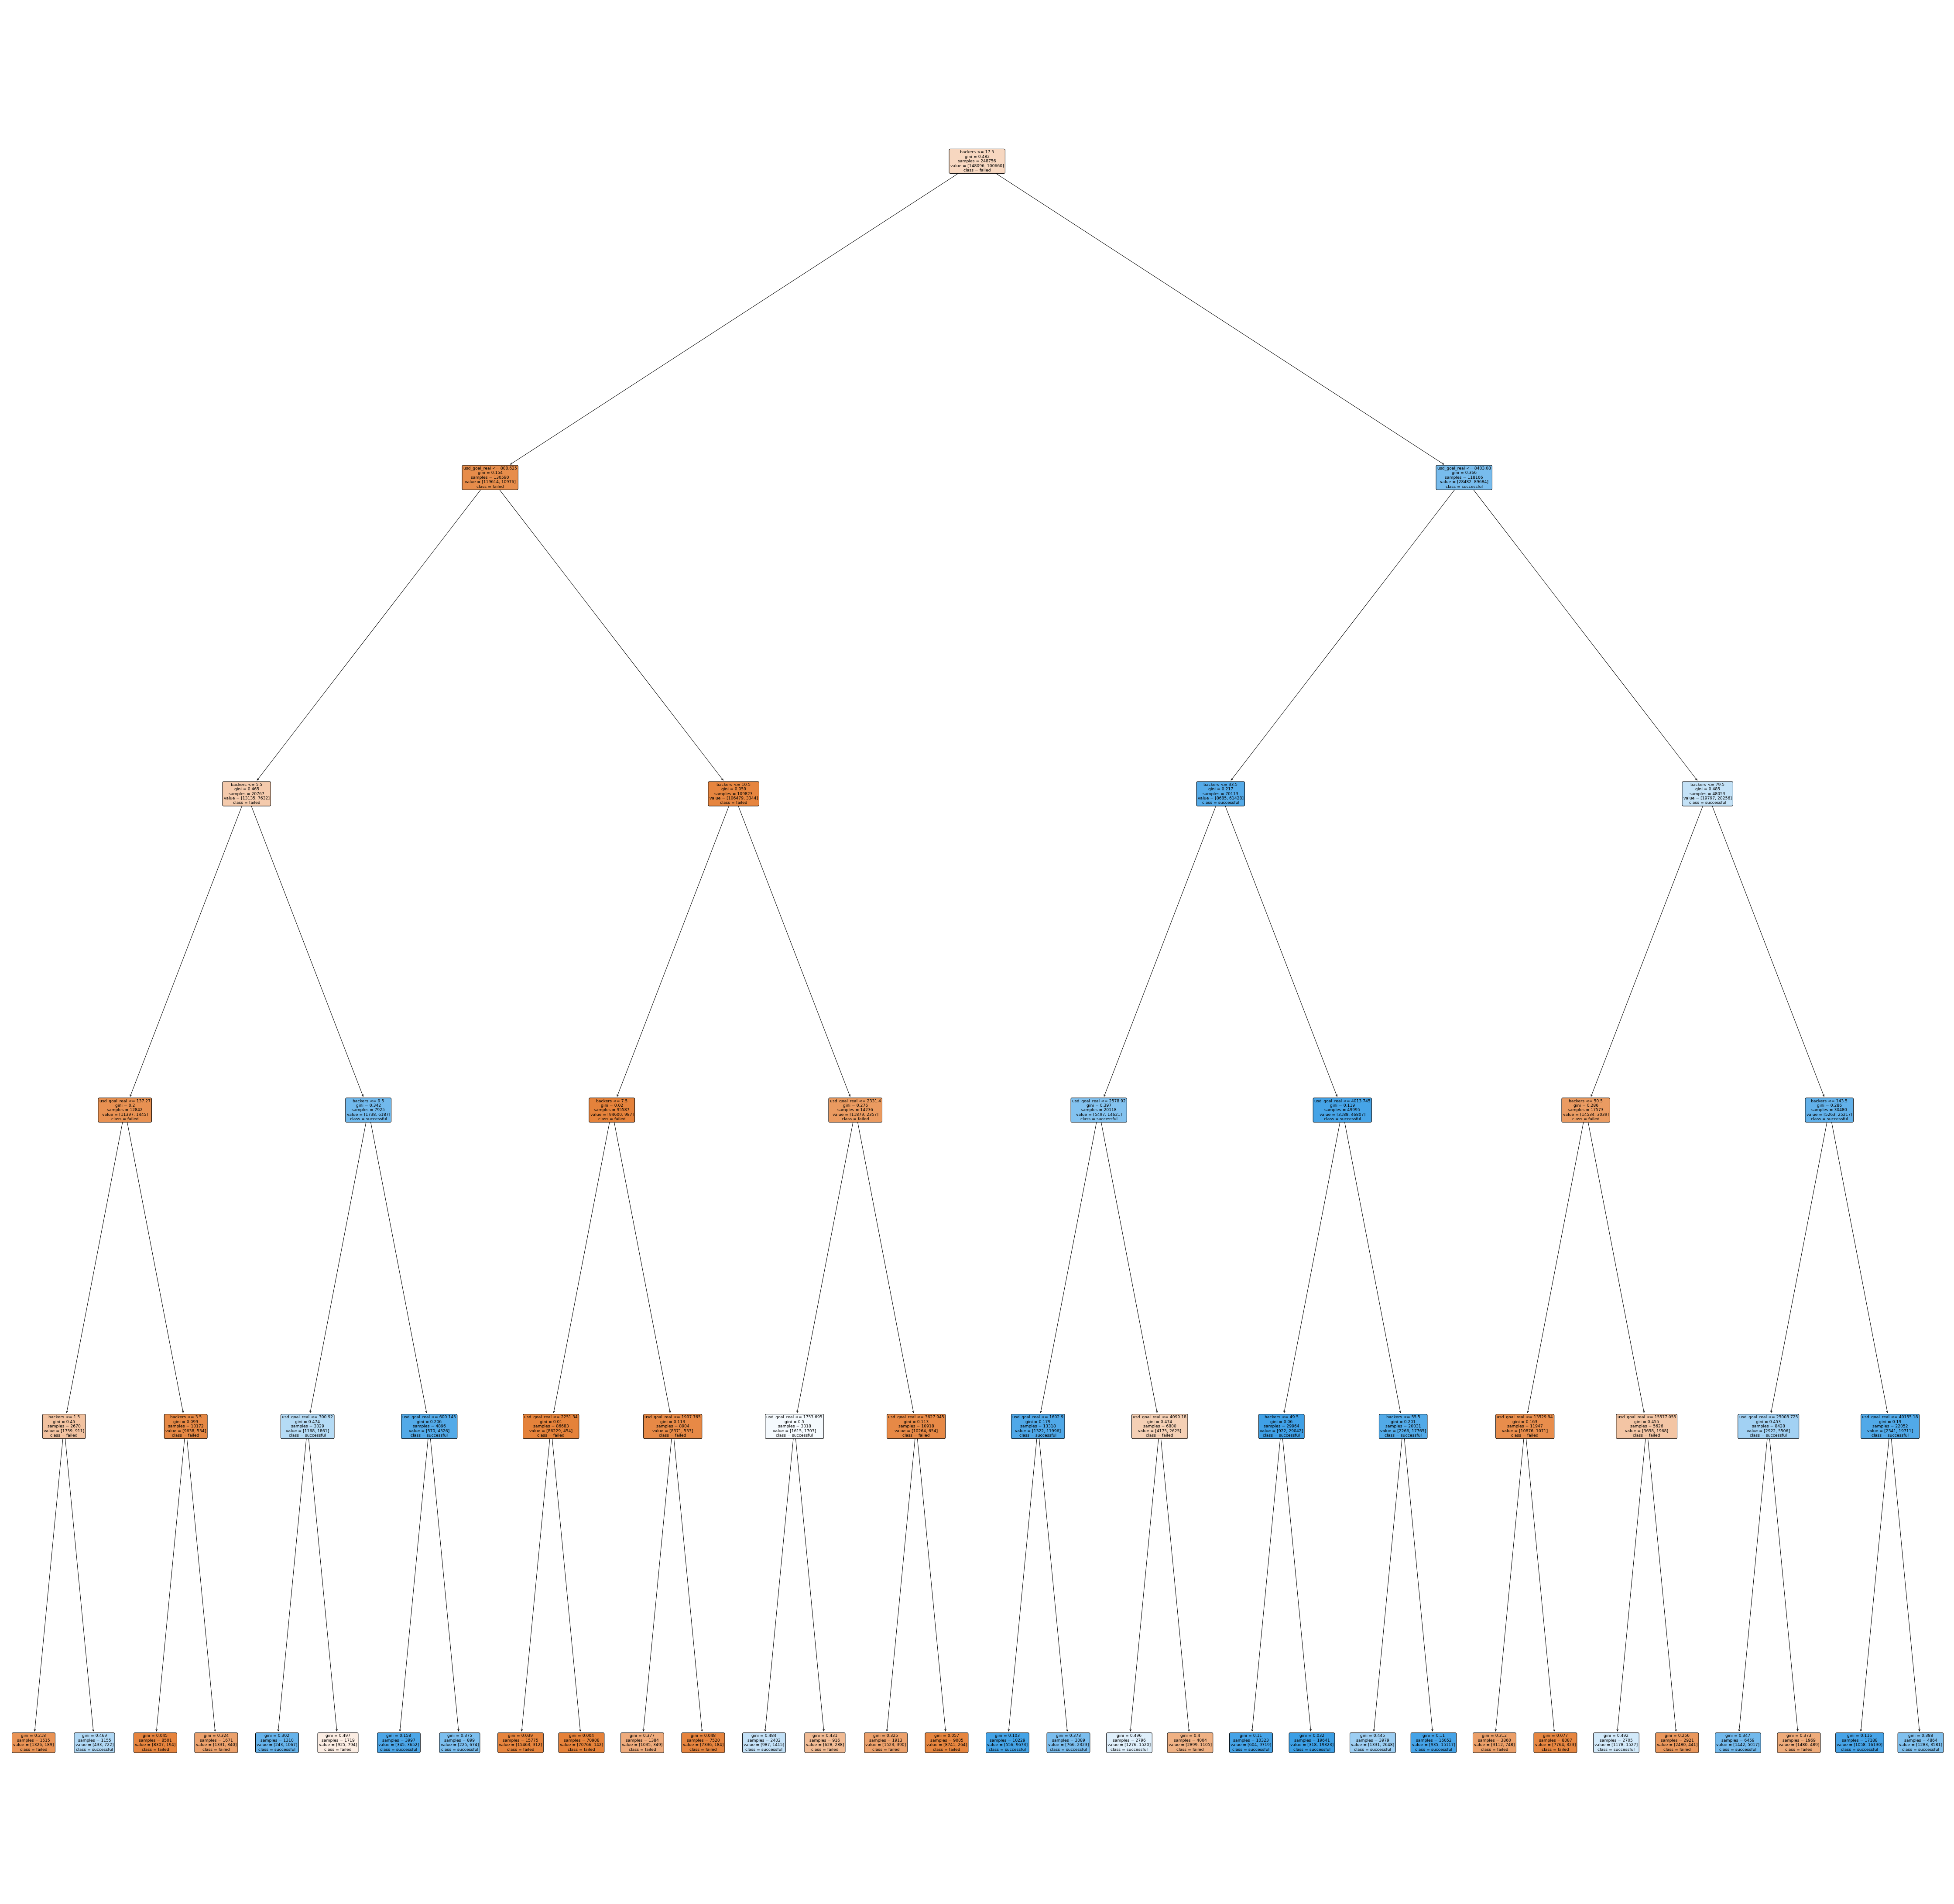

In [207]:
f = plt.figure(figsize=(80,80))
plot_tree(dectree2, filled=True, rounded=True, 
          feature_names=X_train_dt.columns, 
          class_names=["failed","successful"])

As the days between still does not appear, it is not an important variable in determining the state, compared to backers and goal.